![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [5]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [6]:
# Celda 1.1
bikes.groupby('season').total.agg(['min', 'max', 'mean', 'median', lambda x: x.quantile(0.75)-x.quantile(0.25)])

,min,max,mean,median,<lambda_0>
season,,,,,
1,1,801,116.343261,78.0,140.0
2,1,873,215.251372,172.0,272.0
3,1,977,234.417124,195.0,279.0
4,1,948,198.988296,161.0,243.0


In [7]:
## Vemos que durante el verano, que es la temporada 3 hubo el mayor número de alquileres en una hora, que fue 977.
## Esto coincide con el promedio de alquileres, que es el mayor en esta misma temporada.
# En invierno, que es la temporada 1 hubo en promedio el menor número de alquileres por hora, y la menor dispersión de
# los datos

In [8]:
# Celda 1.2
bikes.groupby('hour').total.agg(['min', 'max', 'mean', 'median', lambda x: x.quantile(0.75)-x.quantile(0.25)]).sort_values(by='mean', ascending=False)

,min,max,mean,median,<lambda_0>
hour,,,,,
17,15,970,468.765351,480.5,331.50
18,23,977,430.859649,422.5,323.25
8,8,839,362.769231,392.0,430.00
16,11,783,316.372807,309.5,209.25
19,11,743,315.278509,312.5,226.00
13,11,729,257.787281,226.5,175.00
12,3,757,256.508772,234.5,175.00
15,7,724,254.298246,232.0,177.00
14,12,730,243.442982,212.0,167.25


In [9]:
#Organizamos el resultado en la columna "mean" de mayor a menor y vemos que la hora en la que en promedio más alquileres hay
#es a las 17, es decir a las 5pm, esto tiene sentido dado que es la hora en la que las personas normalmente salen de trabajar
#hacia sus casas

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

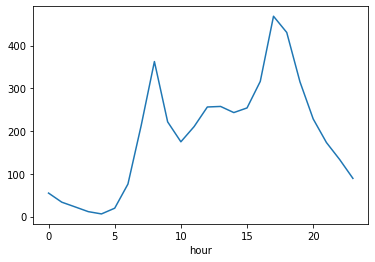

In [10]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

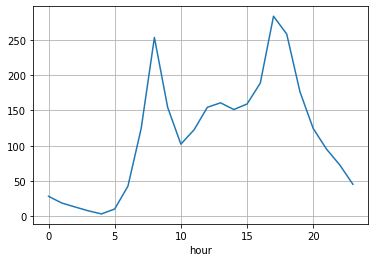

In [11]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 

import matplotlib.pyplot as plt
winter_bikes = bikes.loc[bikes['season']==1]
winter_bikes.groupby('hour').total.mean().plot(label='Invierno')
plt.grid(True)

In [12]:
# En invierno, vemos que el pico de alquileres se da sobre las 17h aproximadamente, con un promedio de alquileres de 
#aproximadamente 270 alquileres en esta hora, teniendo luego un descenso pronunciado a medida que avanza la noche

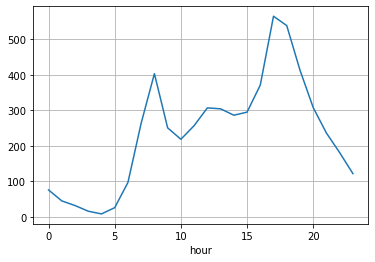

In [13]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
summer_bikes = bikes.loc[bikes['season']==3]
summer_bikes.groupby('hour').total.mean().plot(label='Verano')
plt.grid(True)

In [14]:
# Si bien en verano el pico de alquileres también es hacia las 17h, el promedio es bastante mayor que durante el invierno, 
#ya que en este estación, el promedio a esta hora es de aproximadamente 530 alquileres.

#El patrón en ambas estaciones coincide con las horas pico de entradas a oficinas o lugares de estudio, que son hacia las 7h 
#las 17h

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [15]:
# Celda 3

from sklearn.model_selection import train_test_split
season_dummies = pd.get_dummies(bikes['season'], prefix='season', drop_first=True)

X = pd.concat([bikes['hour'], season_dummies], axis=1)
y = bikes['total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
lm = LinearRegression()

lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

print('Intercepto:', lm.intercept_)
print('Coeficientes:', lm.coef_)
print('R-cuadrado:', lm.score(X_test, y_test))

Intercepto: -8.187223101039052
Coeficientes: [ 10.727042    99.75849224 115.07834048  88.91820601]
R-cuadrado: 0.2135217904404798


In [ ]:
# De acuerdo con los resultados del modelo, tenemos 4 coeficientes. El primer coeficiente es 10.72, que se asocia a la variable
# "hour" y significa que Por cada aumento de una unidad en la hora, se espera un aumento promedio de 10.727042 bicicletas 
#alquiladas, manteniendo constante la variable "season".

#Los siguientes tres coeficientes representan la relación entre "season" y el número de bicicletas alquiladas, con 
#invierno como la categoría de referencia. Por ejemplo, el segundo coeficiene, de 99.75, representa la relación
#entre primavera y el número de bicicletas alquiladas, en comparación con el invierno. Por lo tanto, se espera 
#que en promedio se alquilen 99.75849224 bicicletas más en primavera que en invierno, manteniendo constante la variable "hora".

#En resumen, estos coeficientes indican que tanto la hora como la estación tienen una relación significativa con el número
#de bicicletas alquiladas, y que las estaciones de primavera, verano y otoño tienen un impacto positivo mayor que el invierno 
#en el número de bicicletas alquiladas, una vez que se controla la hora del día.

#Hay varias limitaciones de las regresiones lineales, como por ejemplo la no linealidad entre las variables predictoras y 
#la variable de respuesta, la afectación por outliers, y en general los supuestos de la regresión lineal que 
#es posible que no se cumplan en la vida real.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [20]:
# Celda 4

X = bikes[['hour', 'season']]
y = bikes[['total']]

def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [17]:
# Celda 5

max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())
    



Text(0, 0.5, 'Accuracy')

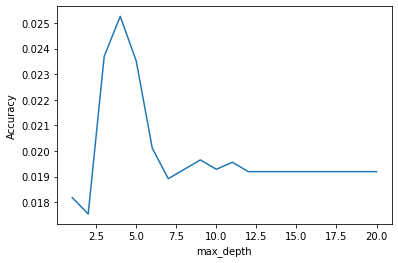

In [18]:
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [21]:
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.025261134067952253, 4)

In [22]:
clf = DecisionTreeClassifier(max_depth=4, random_state=1)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=4, random_state=1)

In [23]:
pd.Series(cross_val_score(clf, X, y, cv=10)).describe()

count    10.000000
mean      0.025261
std       0.006956
min       0.015611
25%       0.020436
50%       0.026183
75%       0.029865
max       0.034894
dtype: float64

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [24]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [25]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [26]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [27]:
# Celda 6

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor

models = {'lr': LogisticRegression(),
          'dt': DecisionTreeRegressor()}

for model in models.values():
    model.fit(X_train, y_train)

y_pred = pd.DataFrame(index=X_test.index, columns=models.keys())
for model in models.keys():
    y_pred[model] = models[model].predict(X_test)
    
from sklearn.metrics import accuracy_score, f1_score

for model in models.keys():
    y_pred[model] = models[model].predict(X_test)
    print(model)
    print('Accuracy:', accuracy_score(y_test, y_pred[model]))
    print('F1 score:', f1_score(y_test, y_pred[model]))


lr
Accuracy: 0.6146666666666667
F1 score: 0.6110363391655451
dt
Accuracy: 0.5453333333333333
F1 score: 0.5441176470588236


In [ ]:
#El modelo de regresión logística parece tener un mejor comportamiento que el árbol de decisión tanto en accuracy como en 
#F1 score

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [ ]:
# Celda 7

from sklearn.ensemble import VotingClassifier, BaggingClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

dt_model_1 = DecisionTreeClassifier(max_depth=3)
dt_model_2 = DecisionTreeClassifier(min_samples_leaf=10)
lr_model = LogisticRegression()

dt_bagging_model_1 = BaggingClassifier(base_estimator=dt_model_1, n_estimators=300)
dt_bagging_model_2 = BaggingClassifier(base_estimator=dt_model_2, n_estimators=300)

dt_bagging_model_1.fit(X_train, y_train)
dt_bagging_model_2.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

for model in [dt_bagging_model_1, dt_bagging_model_2, lr_model]:
    y_pred = model.predict(X_test)
    print(f'Model: {model.__class__.__name__}')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'F1-Score: {f1_score(y_test, y_pred)}')
    
    
for model in [dt_bagging_model_1, dt_bagging_model_2, lr_model]:
    y_pred = model.predict(X_test)
    print(f'Model: {model.__class__.__name__}')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'F1-Score: {f1_score(y_test, y_pred)}')
    
y_pred = ensemble_model.predict(X_test)
print(f'Ensemble Model')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'F1-Score: {f1_score(y_test, y_pred)}')

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [ ]:
# Celda 8


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

In [ ]:
# Celda 9